The model implemented here give 95% accuracy on the train,test and validate dataset.

In [7]:
#Import all the necessary libraries

import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Activation,MaxPooling2D,Dropout
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from keras import regularizers
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.regularizers import l2
import seaborn as sns
import os
%matplotlib inline
train_path = '../input/catdog10000train5000validate/train/train'
valid_path = '../input/catdog10000train5000validate/valid/valid'
test_path  = '../input/catdog10000train5000validate/test/test'

#Use ImageDataGenerator to retrieve dataset images and divide them in test,train,valid with train data =60%,validate = 30% and test = 10%
train_gen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    channel_shift_range=10.,
    fill_mode="nearest"
)
#Use the data augmentation for just the train dataset.
train_batches = train_gen.flow_from_directory(directory=train_path, target_size=(224,224),
    classes=['dog', 'cat'], batch_size=64)
valid_batches = ImageDataGenerator().flow_from_directory(directory=valid_path, target_size=(224,224), 
    classes=['dog', 'cat'], batch_size=64)
test_batches = ImageDataGenerator().flow_from_directory(directory=test_path, target_size=(224,224),
    classes=['dog', 'cat'], batch_size=64,shuffle=False)
# Any results you write to the current directory are saved as output.

Found 10514 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [8]:
#Use Dropout layer in between hidden layers to reduce overfitting.
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(224,224,3),kernel_initializer='glorot_uniform',
           bias_initializer='zeros', kernel_regularizer=l2(0.0005)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu',kernel_initializer='glorot_uniform', 
           bias_initializer='zeros', kernel_regularizer=l2(0.0005)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu',kernel_initializer='glorot_uniform',
           bias_initializer='zeros', kernel_regularizer=l2(0.0005)),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=256, kernel_size=(3, 3), activation='relu',kernel_initializer='glorot_uniform', 
           bias_initializer='zeros', kernel_regularizer=l2(0.0005)),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(2, activation='sigmoid')
    ])

model.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.0001),metrics=['accuracy'])


In [9]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 52, 52, 128)       73856     
_________________________________________________________________
dropout_7 (Dropout)          (None, 52, 52, 128)       0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 26, 26, 128)      

In [10]:
mckpt       = ModelCheckpoint(
    'cat_dog_kaggle.h5', 
	save_best_only=True, 
	monitor='val_loss', 
	mode='auto'
)
reduce_lr_plateau = ReduceLROnPlateau(
    monitor='val_loss', 
	factor=0.1, 
    patience=7, 
	verbose=1, 
    min_delta=1e-4,
	mode='auto')

if os.path.isfile('cat_dog_kaggle.h5'):
    print("Running the Partially Trained Model")
    partially_trained_model = load_model('cat_dog_ckpt.h5')
    history = model.fit_generator(generator=train_batches, steps_per_epoch=len(train_batches), 
                              validation_data=valid_batches, validation_steps=len(valid_batches), 
                              epochs=200,callbacks=[mcp_save,reduce_lr_loss], verbose=1)
else:
    print("Running the Training of Model from Scratch")
    history = model.fit_generator(generator=train_batches, steps_per_epoch=len(train_batches), 
                              validation_data=valid_batches, validation_steps=len(valid_batches), 
                              epochs=200,callbacks=[mckpt,reduce_lr_plateau], verbose=1)
acc = history.history['accuracy'] 
val_acc = history.history['val_accuracy'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend() 
plt.figure() 
plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.show()

NameError: name 'os' is not defined

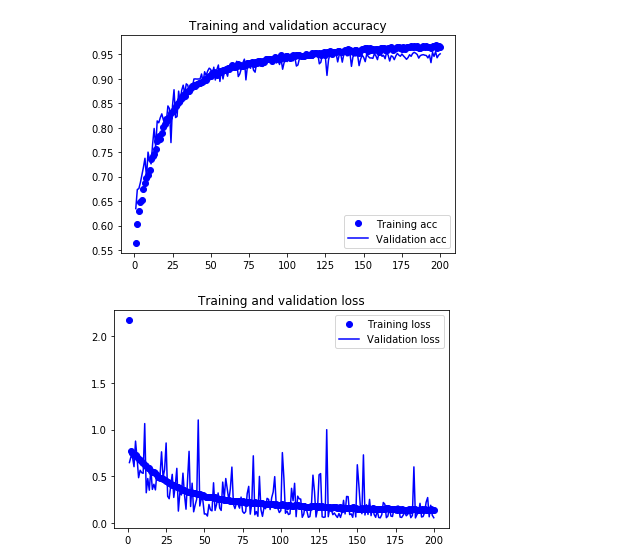


In [ ]:
predictions = model.predict_generator(generator=test_batches, steps=len(test_batches), verbose=0)
pred_label = np.argmax(predictions,axis=1)
classes = np.argmax(predictions, axis=1)
cm = confusion_matrix(test_batches.labels,pred_label)
f,ax = plt.subplots(figsize=(4, 4))
sns.heatmap(cm, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


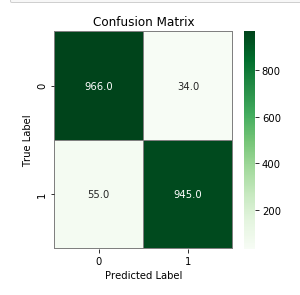

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
tn, fp, fn, tp = cm.ravel()
accuracy = (tn + tp)/(tn + tp + fn +fp)
precision = precision_score(test_batches.labels, pred_label, average='binary')
recall = recall_score(test_batches.labels, pred_label,average='binary')
f1_score = f1_score(test_batches.labels, pred_label, average='binary')

In [ ]:
print("Precision ",precision*100)
print("Recall ",recall*100)
print("F1 Score ",recall*100)
print("Accuracy of the model",accuracy)

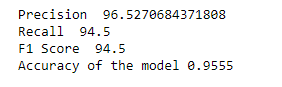